# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [1]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [2]:
# Load data (provided)
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

### 1.1 Display the dimension of the training and test sets. (5 marks)

In [3]:
print("The dimension of training set: ", train_image.shape)
print("The dimension of test set: ", test_image.shape)

The dimension of training set:  (60000, 28, 28)
The dimension of test set:  (10000, 28, 28)


### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

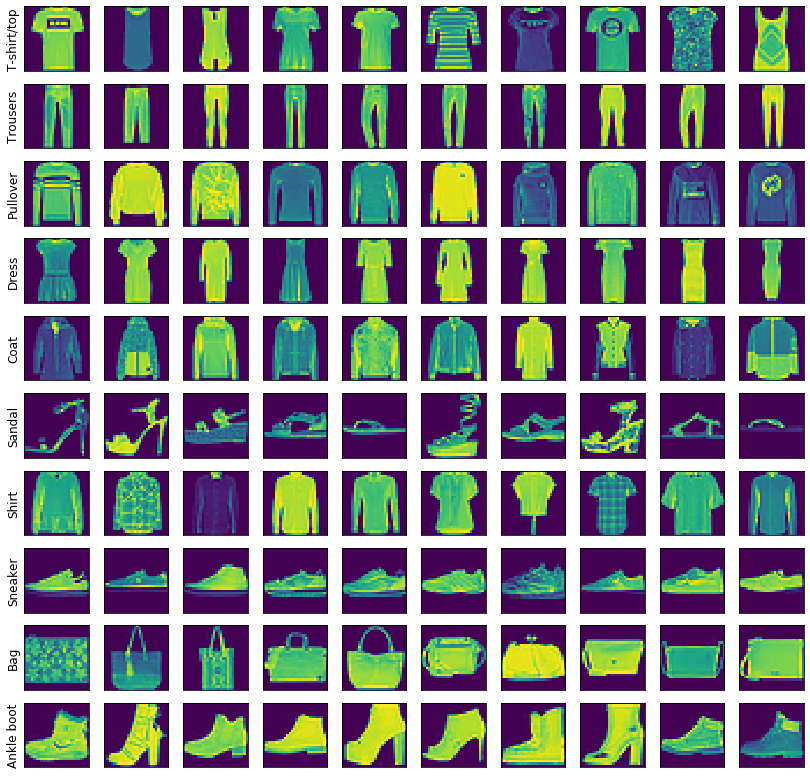

In [4]:
plot_image = []
row_names = ["T-shirt/top", 
            "Trousers", 
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot"]
for i in range(10):
    plot_image.append([]);
for i, img in zip(train_label, train_image):
    plot_image[i].append(img)
    
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(14, 14))

r = 10
c = 10
for i in range(0, r):
    for j in range(0, c):
        img = plot_image[i][j]
        axes[i][j].imshow(img)
        axes[i][j].get_xaxis().set_ticks([])
        axes[i][j].get_yaxis().set_ticks([])
        
for ax, name in zip(axes[:,0], row_names):
    ax.set_ylabel(name, rotation=90, size='large')
       
plt.show()

### 1.3 Display the number of training samples for each class. (5 marks)

In [5]:
ids, counts = np.unique(train_label, return_counts=True)
for i, count in zip(ids, counts):
    print("Class %d: %s" % (i, count))

Class 0: 6000
Class 1: 6000
Class 2: 6000
Class 3: 6000
Class 4: 6000
Class 5: 6000
Class 6: 6000
Class 7: 6000
Class 8: 6000
Class 9: 6000


### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

Yes, the training set is balanced. 
<br>If the training set is unbalanced, the trained model leads to misclassifications. Because the train model is more biased to classes who has many data samples than those who has few.
<br> Also, the measurement metrics will be affected a lot from the imbalancement, so thet gives unaccurate results.

## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 120, kernel_size=5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, img):
        return self.model(img)
net=LeNet()


### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [7]:
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
optimiser = optim.Adam(net.parameters(), lr=learning_rate)
epochs = 17
batch_size = 256
#best so far(e, b): (17, 256)


#validation parameters
enable_validation=True
validation_split_rate = 0.05

#Normalization parameters
mean = 128.0
variance = 128.0

#debug parameter
verbose=2

### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

In [8]:
train_image = (train_image - mean)/variance
train_image=train_image.reshape((60000,1,28,28))
start_time = time.clock()
print("Start training")
net.train()
x_train = torch.from_numpy(train_image).float()
y_train = torch.from_numpy(train_label).long()
print("Input features dimension", x_train.size())
print("Input labels dimension", y_train.size())

if enable_validation:
    if verbose >= 1:
        print("")
        print("validation enabled")
    n = x_train.size(dim=0)
    x_val = x_train[:int(validation_split_rate*n)]
    x_train = x_train[int(validation_split_rate*n):]
    y_val = y_train[:int(validation_split_rate*n)]
    y_train = y_train[int(validation_split_rate*n):]
    if verbose >= 2:
        print("training features dimension", x_train.size())
        print("training labels dimension", y_train.size())
        print("validation features dimension", x_val.size())
        print("validation labels dimension", y_val.size())
    validation = torch.utils.data.TensorDataset(x_val, y_val)
    val_loader = torch.utils.data.DataLoader(validation, batch_size=100, shuffle=True, num_workers=0)

train = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0)

if verbose >= 1:
    print("")
    print("Net Structure")
    print(net)
    print("Loss function", loss_function)
    print("Optimizer: ", optimiser)
    print("Number of Epochs: ", epochs)
    print("Batch Size: ", batch_size)
    print("Verbose: ", verbose)

validation_accs = []
train_accs = []
best_val_acc = 0.0
running_loss = 0.0
#best_net = copy.deepcopy()
for epoch in range(epochs):
    if verbose>=1:
        print("")
        print("Epoch %d/%d, " % (epoch+1, epochs))

    for i, (x, y) in enumerate(train_loader):
        optimiser.zero_grad()
        p = net(x)
        loss = loss_function(p, y)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            if verbose >= 2:
                print('[%d, %5d] avg_loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    #train measurements collection
    train_loss = 0
    prediction = []
    y_shuffle = []
    for i, (x, y) in enumerate(train_loader):
        p = net(x)
        train_loss += loss_function(p, y).sum()
        prediction.extend(p.detach().max(1)[1].numpy())
        y_shuffle.extend(y.numpy())
        
    train_acc = metrics.accuracy_score(prediction, y_shuffle)
    train_accs.append(train_acc)
        
    if verbose >= 1:
        print("train_loss {:.2f}, train_accuracy {:.2%}".format(train_loss.detach().item(), train_acc.tolist()))
    
    #validation data mesurement collection
    if enable_validation:
        val_loss = 0
        prediction = []
        y_shuffle = []
        for i, (x, y) in enumerate(val_loader):
            p = net(x)
            val_loss += loss_function(p, y).sum()
            prediction.extend(p.detach().max(1)[1].numpy())
            y_shuffle.extend(y.numpy())
        
        val_acc = metrics.accuracy_score(prediction, y_shuffle)
        validation_accs.append(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc.tolist()
            #best_net = copy.deepcopy(net)
    
        if verbose >= 1:
            print("validation accuracy {:.2%}, best validation accuracy {:.2%}, validation loss {:.2f}".format(val_acc, best_val_acc, val_loss))

# if enable_validation:
#     net=best_net
print("")
print("Training end.")
duration = time.clock() - start_time
print("traning takes {:.2f} seconds".format(duration))

Start training
Input features dimension torch.Size([60000, 1, 28, 28])
Input labels dimension torch.Size([60000])

validation enabled
training features dimension torch.Size([57000, 1, 28, 28])
training labels dimension torch.Size([57000])
validation features dimension torch.Size([3000, 1, 28, 28])
validation labels dimension torch.Size([3000])

Net Structure
LeNet(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Flatten()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): LogSoftmax()
  )
)
Loss function C

### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [9]:
test_image = (test_image - mean)/variance
test_image=test_image.reshape((10000,1,28,28))
start_time = time.clock()
print("Start Testing")
net.eval()
x_test = torch.from_numpy(test_image).float()
y_test = torch.from_numpy(test_label).long()

duration = time.clock() - start_time
prediction = net(x_test).detach().max(1)[1].numpy()
print("test takes {:.2f} seconds".format(duration))

Start Testing
test takes 0.02 seconds


### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [10]:
test_acc = metrics.accuracy_score(prediction, y_test)
print("Test accuracy: {:.2%}".format(test_acc))

Test accuracy: 89.70%


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [12]:
confusion = metrics.confusion_matrix(prediction, y_test)
print(confusion)
print(row_names)

[[879   2  16  24   1   0 148   0   3   0]
 [  0 972   2   1   0   0   0   0   1   0]
 [ 12   1 846   8  64   0  55   0   3   0]
 [ 11  17  10 905  43   1  20   0   6   0]
 [  3   2  52  21 801   0  51   0   2   0]
 [  2   0   1   0   0 972   0  11   1   7]
 [ 88   6  72  37  89   0 716   0   5   0]
 [  0   0   0   0   0  18   0 979   2  69]
 [  5   0   1   4   2   3  10   2 977   1]
 [  0   0   0   0   0   6   0   8   0 923]]
['T-shirt/top', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

### 3.2 Test your network on the real images and display the classification results. (5 marks)

### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?